## Tweeting for/against Nordstrom

Recent events have led to Nordstrom dropping a line of their clothing from their typical lineup - that of Ivanka Trump (http://n.pr/2ktyVqt). As would be expected, this has led to all sorts of reactions from a variety of sources. A Nordstrom spokesperson explained the decision:

    "Over the past year, and particularly in the last half of 2016, sales of the brand have steadily declined to the point where it didn't make good business sense for us to continue with the line for now. We've had a great relationship with the Ivanka Trump team. We've had open conversations with them over the past year to share what we've seen and Ivanka was personally informed of our decision in early January," said the spokesperson."
    
The decision by Nordstrom gained public attention on Feb 3rd and 4th. The president responded publicly (on Twitter) to the decision by Nordstrom on the morning of February 8:

    "My daughter Ivanka has been treated so unfairly by @Nordstrom. She is a great person -- always pushing me to do the right thing! Terrible!"

My goal is to examine the reaction on Twitter to these two events: the initial coverage on February 3rd and the followup response on February 8th. I use the Twitter API to gather tweets with the #Nordstrom tag and analyze their sentiment and popularity, with differentiations based on whether the president or his daughter are mentioned.

First, the setup of packages

In [56]:
%matplotlib inline
import tweepy
from pylab import *
from random import *
from scipy import *
from matplotlib import *
import csv, sys
import re,math
import numpy as np
import pandas as pd
from pandas import datetime
rcdefaults()
matplotlib.rc('font',family='Bitstream Vera Serif')

I am using the tweepy package, which is available here for reference: http://www.tweepy.org/.

First, we set up the Twitter API with the necessary Key and Secret identification, set up at https://apps.twitter.com/. This is a required step to gain access to Twitter via tweepy and python. We use this to start up an API session (using specific options to avoid errors and being blocked by Twitter for too many requests).

In [5]:
consumerKey = '' #### Insert Key Here from Twitter API
consumerSecret = '' #### Insert Secret Key here from Twitter API

### set up tweepy.OAuthHandler with authentication using the user's key and secret
auth = tweepy.OAuthHandler(consumer_key=consumerKey, 
                        consumer_secret=consumerSecret)

### connect to twitter API with authentication
api = tweepy.API(auth, retry_count=3, retry_delay=5, retry_errors=set([401, 404, 500, 503]), 
        wait_on_rate_limit_notify=True, wait_on_rate_limit=True )

Now, we are connected, and we want to gather some tweets!

Because there are SO MANY tweets with #Nordstrom, I've chosen to get the first of every 10,000 tweets with a pagination of 10,000 as well, restricted to the existence of the hashtag and the requirement that the tweet is in English.

In [4]:
page_count = 0  
results = []

### get only the first of N tweets out of every page, for M pages
N = 10000
for tweets in tweepy.Cursor(api.search, q='%23nordstrom', lang='en', count=N, result_type="recent").pages():  
    page_count += 1  
    for i in tweets:
        results.append(i)
    if page_count >= 10000: ### how many pages to go through
        break
print len(results) ### --> how many tweets we get out!

Rate limit reached. Sleeping for: 541
65206


We've gotten about 65,000 tweets - a good number to work with! Next, we want to reformat all of that data into a more useful format...

In [5]:
### using the tweets we snagged, set up a nice dataframe with only the info we're interested in
def toDataFrame(tweets):
    DataSet = pd.DataFrame()
    DataSet['tweetText'] = [tweet.text for tweet in tweets]
    DataSet['tweetMonth'] = [int(tweet.created_at.strftime("%m")) for tweet in tweets]
    DataSet['tweetDay'] = [tweet.created_at.strftime("%d") for tweet in tweets]
    DataSet['userLocation'] = [tweet.user.location for tweet in tweets]
    DataSet['userTimezone'] = [tweet.user.time_zone for tweet in tweets]
    DataSet['tweetRetweetCt'] = [tweet.retweet_count for tweet in tweets]
    DataSet['tweetFavoriteCt'] = [tweet.favorite_count for tweet in tweets]
    DataSet['tweetCreated'] = [tweet.created_at for tweet in tweets]
    return DataSet
### sidenote -- this is modeled off of the excellent tweepy crash course by http://blog.impiyush.com/2015/03/data-analysis-using-twitter-api-and.html

### Put those results into a nice dataframe
DataSet = toDataFrame(results)
print len(DataSet)

Now, I saved the results in a pickle so that I have a static file of the same tweets to work from. This is important, as Twitter tends not to make tweets available via the API for much more than a week (also, because the results would change every single time I queried the system). I've made the tweets over this time range also available via the pickle in the GitHub repo.

In [7]:
#import pickle
#DataSet.to_pickle('Tweets1.pickle')
DataSet = pd.read_pickle('Tweets1.pickle')

In [10]:
### let's check out the first few tweets
DataSet.head()

,tweetText,tweetMonth,tweetDay,userLocation,userTimezone,tweetRetweetCt,tweetFavoriteCt,tweetCreated
0,@MSNBC And #Nordstrom stock went up yesterday.,2,09,"Ottawa, Ontario Canada",Quito,0,1,2017-02-09 13:01:08
1,RT @Impeach_D_Trump: So Called President Trump...,2,09,USA,Eastern Time (US & Canada),4086,0,2017-02-09 13:01:08
2,RT @Bourdain: Glad our president is bravely ta...,2,09,,None,1285,0,2017-02-09 13:01:06
3,RT @thealicecutler: So glad @realDonaldTrump i...,2,09,"Boulder, Colorado, USA",Mountain Time (US & Canada),141,0,2017-02-09 13:01:06
4,RT @thealicecutler: So glad @realDonaldTrump i...,2,09,United States,None,141,0,2017-02-09 13:01:04


Awesome. I've gotten a bunch of relevant tweets! Now I can dig in and analyze them. The inital analysis here is simply to look at the incidence of tweets with '#Nordstrom' over the time period we have (which is about a week).

First, we convert the tweetCreated times to a pandas datetime object to facilitate an analysis over time

In [12]:
def parser(X):
    return [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in X]

DataSet['datetime'] = parser(DataSet['tweetCreated'])
DataSet.set_index('datetime', drop=False, inplace=True)

Now, I also want to examine the incidence of mentions of the relevant topics here - specifically, whether the words 'ivanka' or 'trump' appear in the text of the tweet as well as the hashtag of interest. It is possible some of the '#Nordstrom' tweets are about the store/shopping experience and not about the recent news. The differentiation based on tweet text, using 1/0 tagging, will help to get a handle on this.

In [9]:
### if the text appears in the tweet, we assign it a '1', otherwise it remains '0'.
ivank = [0]*len(DataSet); trump = [0]*len(DataSet)
for i,Line in enumerate(DataSet['tweetText']):
    set1 = re.split('\s+', Line.lower())
    if 'ivanka' in set1:
        ivank[i] = int(1)
    if 'trump' in set1:
        trump[i] = 1
ivank = np.array(ivank); trump = np.array(trump)
DataSet['ivank'] = ivank; DataSet['trump'] = trump

Now we can look at how frequently these three instances occur:
1. '#Nordstrom' (blue)
2. '#Nordstrom' and 'trump' (orange)
3. '#Nordstrom' and 'invanka' (cyan)

This is shown in the two plots below. The only difference between these two plots is the time resolution - the top plot is coarser, binned at every hour; the bottom is binned at every 2 minutes.

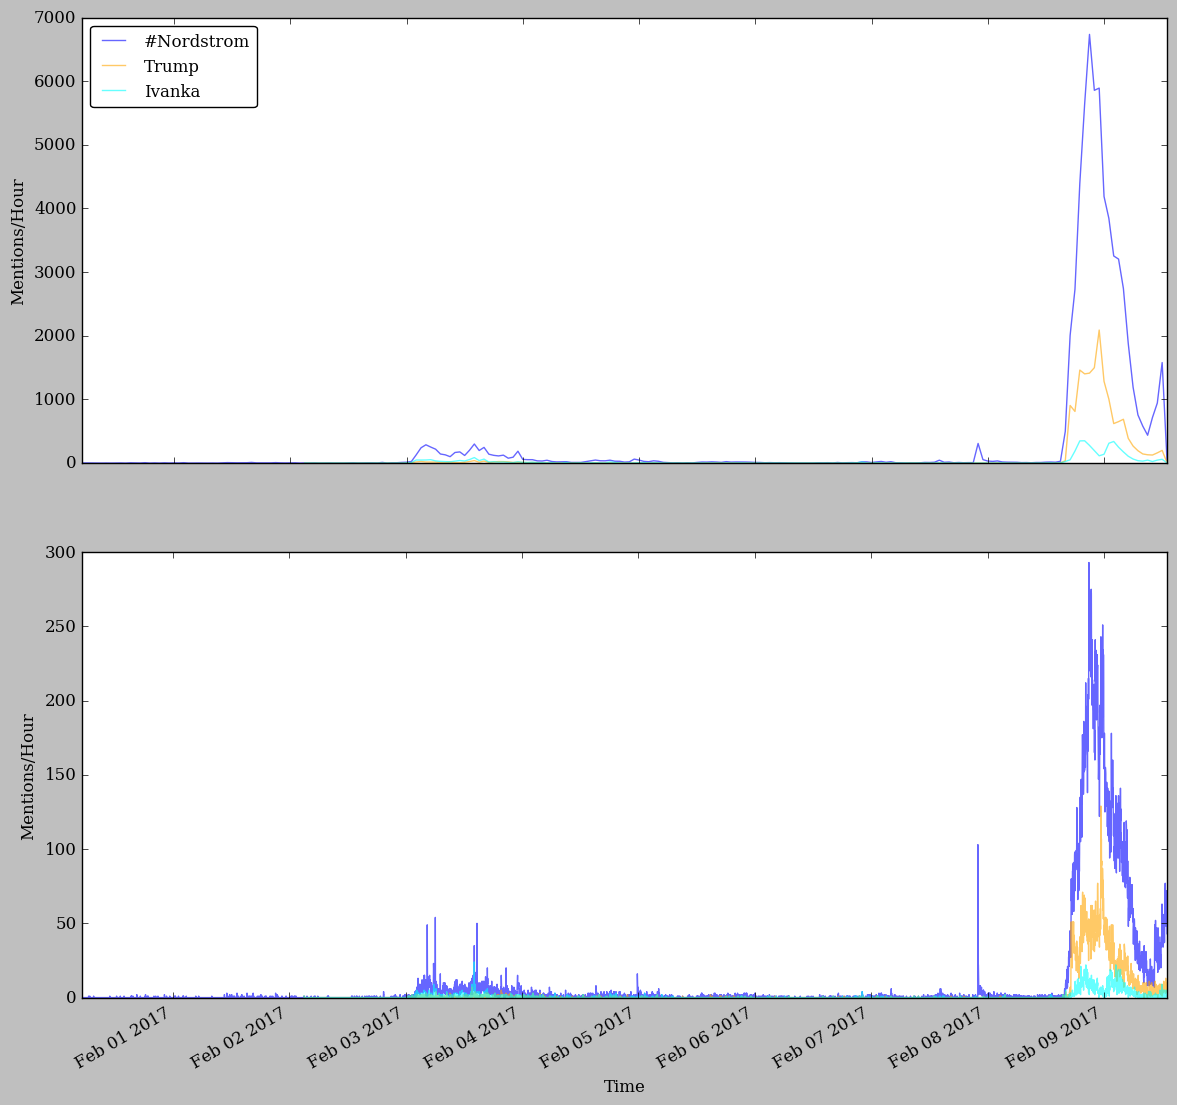

In [55]:
f,((ax,bx)) = plt.subplots(2,1, figsize=(14,14))
chunk = ['1H','120S']
for i,axs in enumerate([ax,bx]):
    axs.plot(DataSet['tweetCreated'].groupby(pd.TimeGrouper(freq=chunk[i])).count(), label='#Nordstrom', alpha=0.6)#kind='bar')
    axs.plot(DataSet['tweetCreated'][(DataSet['trump']==1)].groupby(pd.TimeGrouper(freq=chunk[i])).count(), color='orange', label='Trump', alpha=0.6)
    axs.plot(DataSet['tweetCreated'][(DataSet['ivank']==1)].groupby(pd.TimeGrouper(freq=chunk[i])).count(), color='cyan', label='Ivanka', alpha=0.6)
    axs.set_xlabel('Time'); axs.set_ylabel('Mentions/Hour')
    f.autofmt_xdate()
ax.legend(fancybox=True, loc=2, prop={'size':12})
plt.show()

It is clear that Nordstrom did not get a whole lot of tweet coverage until February 3rd and 4th when the decision by Nordstrom to remove the line of clothing from their inventory began to be reported more widely. This certainly led to peaked upticks in #Nordstrom mentions each day.

However, things overall quieted down a bit after that, albeit with slightly higher levels of mentions, and many more inclusions of 'ivanka' under Nordstrom hashtag than prior to the 3rd.

Late on Feb 7th, there was another another (and much stronger) peak in #Nordstrom mentions. Oddly, mentioned dropped off yet again after this! The president tweeted the following morning about Nordstrom's decision, leading to a stronger and more sustained response. (We have to remember this is a GMT time, not a EST/PST/etc. timestamp).

If we take into account the time of day, it may be that until Twitter users largely left work in the evening that the hashtag was picked up again with more earnest, continuing throughout the evening, and settling down again in the hours before daylight. However, this was only temporary -- there are some indications that the day of Feb 9th will bring another strong peak of Twitter-based discussion. 

All right, now let's look at the content of these tweets a bit more closely. I use what is essentially a "sentiment dictionary". This is afinn, which scores each words based on their positivity or negativity. More information can be found at https://github.com/wooorm/afinn-111.

Obviously, we have to realize this is inexact, but it is unreasonable to examine and score the sentiment of each tweet individually and sentiment analysis is a more and more common approach to analyzing how humans react (whether on Twitter, other social media, online reviews of products, restaurants, etc....).

In [8]:
### try a sentiment analysis
afinnfile = open('AFINN-111.txt')
scores = {} # initialize an empty dictionary
for line in afinnfile:
    term, score  = line.split("\t")  # The file is tab-delimited
    scores[term] = int(score)  # Convert the score to an integer

sentiment_score = []
for i,Line in enumerate(DataSet['tweetText']):
    sent_score=0
    for Word in re.split('\s+', Line.lower()):
        if Word in scores:
            sent_score+=(scores[Word])
    sentiment_score.append(int(sent_score))
sentiment_score = array(sentiment_score)
DataSet['sent'] = sentiment_score

So, we use the list of afinn words to assign a sentiment score to the tweets. We split this up based again on whether Nordstrom is mentioned in isolation or not. We can examine the spread of sentiments, as below:

65206 4149 15972


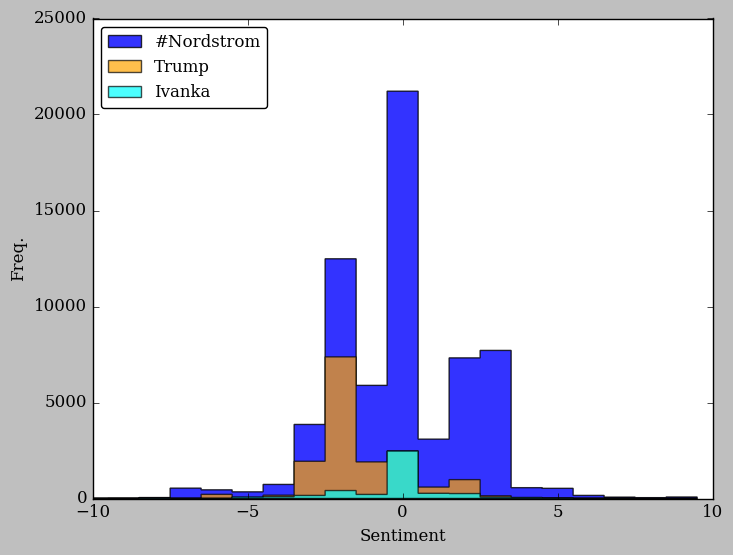

In [10]:
print len(sentiment_score), len(ivank[np.where(ivank==(1))]), len(trump[np.where(trump==(1))])
bns = arange(-10.5,10.5,1)
hist(sentiment_score, color='blue', histtype='stepfilled', alpha=0.8, bins = bns, label='#Nordstrom')
hist(sentiment_score[np.where(trump==(1))], color='orange', histtype='stepfilled', alpha=0.7, bins=bns, label='Trump')
hist(sentiment_score[np.where(ivank==(1))], color='cyan', histtype='stepfilled', alpha=0.7, bins=bns, label='Ivanka')
plt.legend(fancybox=True, loc=2, prop={'size':12})
xlabel('Sentiment'); ylabel('Freq.'); xlim(-10,10)
plt.show()

The overall mentions of #Nordstrom are trimodal here - a positive peak, a neutral peak, and a negative peak. The mentions of 'trump' have a strong negative peak and minimumal positive peak. The 'ivanka' mentions are most strongly peaked at neutral, with a weak negative peak.

But how much of this is in response to the events of the past week? Below, I split the data up to examine Feb 2 (before any news coverage) and the more recent tweets from Feb 9 (representing much of the recent reactions to the news and the tweeted response from the president). This allows us to look at what we expect the "background" distribution of Nordstrom mentions to look like and compare this to the recent Twitter reaction.

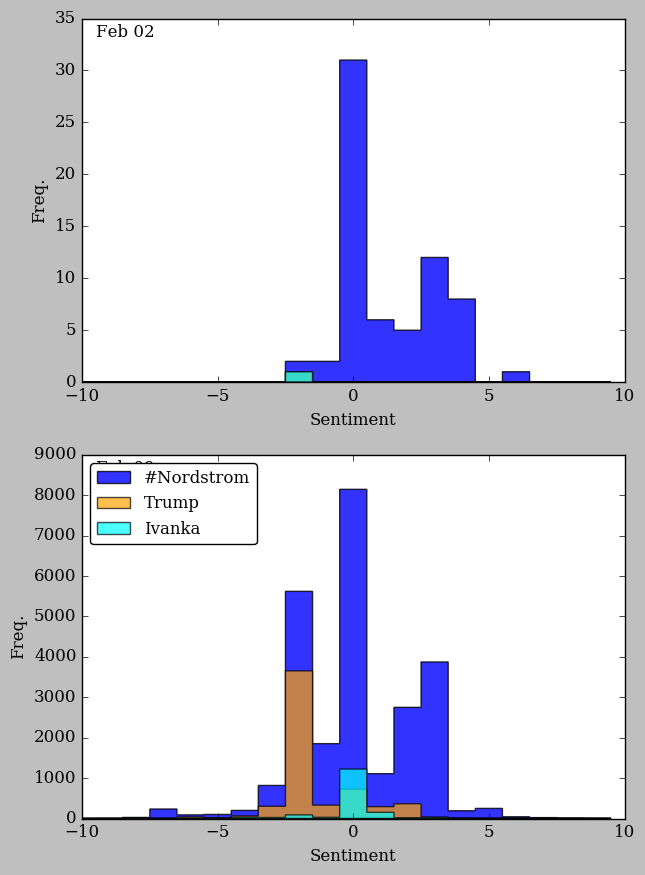

In [45]:
f,((ax,bx)) = plt.subplots(2,1, figsize=(7,10))
days = ['02','09']
bns = arange(-10.5,10.5,1)
for i,axs in enumerate([ax,bx]):
    axs.hist(DataSet['sent'][DataSet['tweetDay']==days[i]], color='blue', histtype='stepfilled', alpha=0.8, bins = bns, label='#Nordstrom')
    axs.hist(DataSet['sent'][(DataSet['trump']==(1)) & (DataSet['tweetDay']==days[i])], color='orange', histtype='stepfilled', alpha=0.7, bins=bns, label='Trump')
    axs.hist(DataSet['sent'][(DataSet['ivank']==(1)) & (DataSet['tweetDay']==days[i])], color='cyan', histtype='stepfilled', alpha=0.7, bins=bns, label='Ivanka')
    axs.set_xlabel('Sentiment'); axs.set_ylabel('Freq.'); axs.set_xlim(-10,10)
    axs.annotate('Feb '+days[i], xy=(-9.5,0.95*max(axs.get_ylim())))
plt.legend(fancybox=True, loc=2, prop={'size':12})
plt.show()

The pre-news coverage of Nordstrom was almost exclusively neutral and positive, and we expect that a certain amount of this Twitter activity to continue. However, in terms of numbers, it is a small proportion of the Feb 9 activity. From Nordstrom's point of view, this may be an amplification of their usual brand sentiment.

It is clear from this analysis that the negative peak is almost entirely attributable to recent events - perhaps a troubling turn for Nordstrom's brand recognition. However, it is difficult to discern where the negativity is aimed at Nordstrom or at Trump, as the incidences of 'trump' in conjunction with '#Nordstrom' is skewed extremely towards the negative sentiment.

Alright, now a brief look at retweeting and favorite tweets from our sample, with the tweets segmented in the same way as previously discussed.

First - let's look at "pre-news" sentiment (Feb 2) vs more recent sentiment (Feb 9) for the number of retweets a Nordstrom hashtag receives.

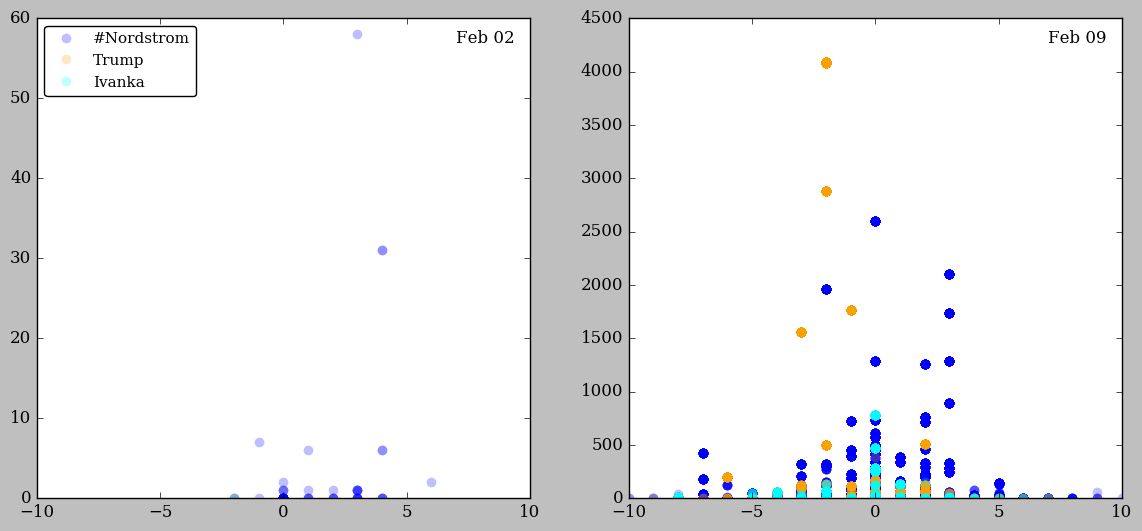

In [53]:
### sentiment vs retweets/favorites
f,((ax,bx)) = plt.subplots(1,2, figsize=(14,6))
days = ['02','09']
for i,axs in enumerate([ax,bx]):
    axs.plot(DataSet['sent'][(DataSet['tweetDay']==days[i])], DataSet['tweetRetweetCt'][(DataSet['tweetDay']==days[i])], 'o', alpha=0.25, color='blue', ms=7, mec='None', label='#Nordstrom')
    axs.plot(DataSet['sent'][(DataSet['trump']==1)&(DataSet['tweetDay']==days[i])], DataSet['tweetRetweetCt'][(DataSet['trump']==1)&(DataSet['tweetDay']==days[i])], 'o', alpha=0.25, color='orange', ms=7, mec='None', label='Trump')
    axs.plot(DataSet['sent'][(DataSet['ivank']==1)&(DataSet['tweetDay']==days[i])], DataSet['tweetRetweetCt'][(DataSet['ivank']==1)&(DataSet['tweetDay']==days[i])], 'o', alpha=0.25, color='cyan', ms=7, mec='None', label='Ivanka')
    axs.set_xlim(-10,10)
    axs.annotate('Feb '+days[i], xy=(7, 0.95*max(axs.get_ylim())))
ax.legend(fancybox=True, loc=2, numpoints=1, prop={'size':11})
plt.show()

As before, the "pre-news" sentiment is largely neutral and positive, with very few tweets receiving more than 10 retweets. After, the most re-tweeted #Nordstrom-only mentions still tend to be neutral and positive, with the most re-tweeted #Nordstrom-trump combo being more negative.

We examine the same for the favorite counts below, without any clear, useful insight.

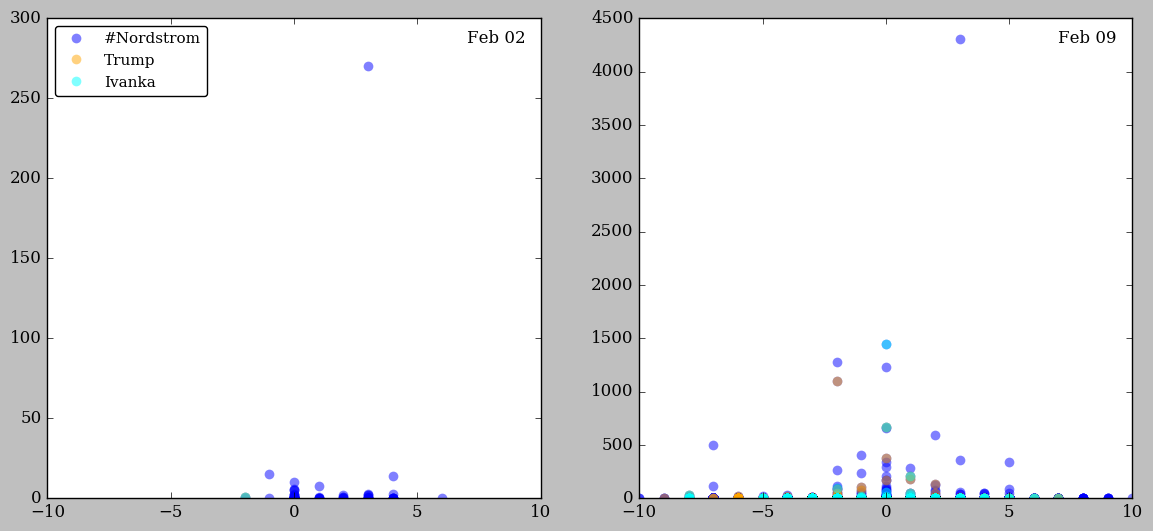

In [54]:
### sentiment vs retweets/favorites
f,((ax,bx)) = plt.subplots(1,2, figsize=(14,6))
days = ['02','09']
for i,axs in enumerate([ax,bx]):
    axs.plot(DataSet['sent'][(DataSet['tweetDay']==days[i])], DataSet['tweetFavoriteCt'][(DataSet['tweetDay']==days[i])], 'o', alpha=0.5, color='blue', ms=7, mec='None', label='#Nordstrom')
    axs.plot(DataSet['sent'][(DataSet['trump']==1)&(DataSet['tweetDay']==days[i])], DataSet['tweetFavoriteCt'][(DataSet['trump']==1)&(DataSet['tweetDay']==days[i])], 'o', alpha=0.5, color='orange', ms=7, mec='None', label='Trump')
    axs.plot(DataSet['sent'][(DataSet['ivank']==1)&(DataSet['tweetDay']==days[i])], DataSet['tweetFavoriteCt'][(DataSet['ivank']==1)&(DataSet['tweetDay']==days[i])], 'o', alpha=0.5, color='cyan', ms=7, mec='None', label='Ivanka')
    axs.set_xlim(-10,10)
    axs.annotate('Feb '+days[i], xy=(7, 0.95*max(axs.get_ylim())))
ax.legend(fancybox=True, loc=2, numpoints=1, prop={'size':11})
plt.show()

In summary, I mostly wanted to see how things exploded on Twitter. I don't actually tweet myself, but I do find it to be a fascinating source of human behavior.

For Nordstrom, the most important thing would be to discern the source of negativity. From the data, it remains unclear whether the Twitter negativity is aimed at Nordstrom or at the president. There are several ways it may be possible to leverage greater insight on this point:
1. Combine Twitter analysis with in-store and online traffic
2. Combine Twitter analysis with in-store and online purchasing data 
3. Dive deeper into tweet analysis with NLP fuzzy matching of phrases
4. Pick a sample of tweets to analyze more in-depth where negativity is aimed
5. Combine Twitter analysis with other relevant retail information
